In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error

import eli5
from eli5.sklearn import PermutationImportance
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
#from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
#%matplotlib widget

In [3]:
df_photo = pd.read_csv('./ast596_final/data/stripe82candidateVar_v1.1.dat',skiprows=5, header=1,index_col=0,sep='\s+')
colnames = ['ID','Priority','Flags','Teff','eTeff','NTeff','logg','elogg','Nlogg','Z','eZ','NZ']
df_spec = pd.read_csv('./ast596_final/data/t3.txt',sep='\s+',skiprows=26,header=None,index_col=0,names=colnames)
df = pd.merge(df_spec, df_photo, on='ID',how='left')
df_nonan = df[(df['Teff'] != -9999.0) & (df['logg'] != -9999.0) & (df['Z'] != -9999.0)]

# Teff and g

In [4]:
df_Y = df_nonan[['Teff','logg']]
df_X = df_nonan[['ug','gr','ri','iz']]
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_X_norm = (train_X - train_stats['mean']) / train_stats['std']
test_X_norm = (test_X - train_stats['mean']) / train_stats['std']

In [41]:
def keras_custom_lossfun(y_actual,y_predicted):
    custom_loss_value = (((((y_actual[:,0]-5416.829394)/671.423738) - ((y_predicted[:,0]-5416.829394)/671.423738) ))**2 +
                         ((((y_actual[:,1]-3.989970)/0.444576) - ((y_predicted[:,1]-3.989970)/0.444576) ))**2
                        )
    return custom_loss_value

In [42]:
def build_model(n):
 
    inpt = keras.Input(shape=(n,), name='Input_layer')
    x = keras.layers.Dense(128, activation='relu')(inpt)
    #x = keras.layers.Dense(128, activation='relu')(x)
    #x = keras.layers.Dropout(0.1)(x)
    gen_dense_final = keras.layers.Dense(128, activation='relu')(x)
    
    temp = keras.layers.Dense(64, activation='relu')(gen_dense_final)
    temp = keras.layers.Dense(32, activation='relu')(temp)
    temp = keras.layers.Dense(32, activation='relu')(temp)
    temp_out = keras.layers.Dense(1, activation='relu')(temp)
    
    logg = keras.layers.Dense(64, activation='relu')(gen_dense_final)
    logg = keras.layers.Dense(32, activation='relu')(logg)
    logg = keras.layers.Dense(32, activation='relu')(logg)
    logg_out = keras.layers.Dense(1, activation='relu')(logg)
    
    
    model_out = keras.layers.concatenate([temp_out,logg_out])
        
    model = keras.Model(inputs=inpt, outputs=model_out)
    
    model.compile(loss=keras_custom_lossfun,
                 optimizer='adam',
                 metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])
    
    
    return model


In [43]:
model_temp = build_model(len(train_X.columns))

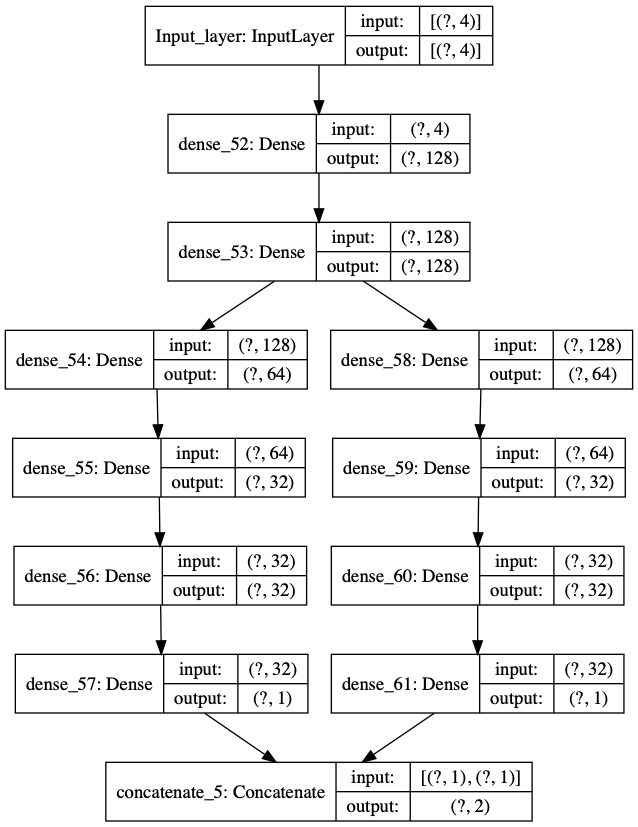

In [56]:
keras.utils.plot_model(model_temp,'split_model.png',show_shapes=True)

In [44]:
history = model_temp.fit(train_X_norm, train_y, epochs=300, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/300
2524/2524 [==============================] - 1s 347us/sample - loss: 92.3790 - mae: 2682.2139 - mse: 14615119.0000 - msle: 21.1452 - mape: 73.9231 - kullback_leibler_divergence: 1.4002 - val_loss: 67.8404 - val_mae: 2646.5103 - val_mse: 14246019.0000 - val_msle: 7.4617 - val_mape: 58.2908 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 2/300
2524/2524 [==============================] - 0s 59us/sample - loss: 38.6296 - mae: 1800.7032 - mse: 8137763.5000 - msle: 2.2813 - mape: 40.3678 - kullback_leibler_divergence: -9.8919e-05 - val_loss: 4.4896 - val_mae: 397.8799 - val_mse: 566634.1250 - val_msle: 0.0230 - val_mape: 14.0887 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 3/300
2524/2524 [==============================] - 0s 58us/sample - loss: 2.2944 - mae: 259.1338 - mse: 230658.6406 - msle: 0.0144 - mape: 10.0049 - kullback_leibler_divergence: -9.8919e-05 - val_loss: 1.7172 - val_mae: 187.4679 - val_mse: 140283.9062 -

In [45]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
295,0.699764,56.730480,11605.231445,0.003525,4.646591,-0.000099,0.906582,62.212795,15948.199219,0.004486,5.089570,0.0,295
296,0.706281,56.865837,11867.324219,0.003584,4.657980,-0.000099,0.976516,83.660736,24481.546875,0.005008,5.689253,0.0,296
297,0.682598,56.609741,11501.478516,0.003463,4.599656,-0.000099,0.885192,59.534328,15731.850586,0.004411,4.989183,0.0,297
298,0.700554,56.535015,11724.367188,0.003576,4.625474,-0.000099,1.018960,85.537216,24331.066406,0.005145,5.770372,0.0,298
299,0.701725,55.940334,11449.816406,0.003558,4.621361,-0.000099,0.903150,59.951557,15276.291016,0.004408,5.119931,0.0,299


Text(0, 0.5, 'loss')

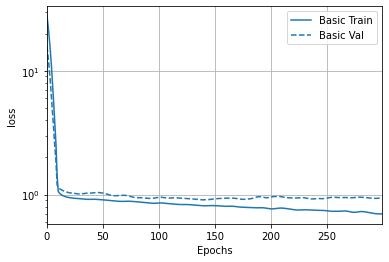

In [58]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = 'loss')
#plt.ylim([0, 20])
plt.yscale('log')
plt.ylabel('loss')

In [47]:
test_predictions = model_temp.predict(test_X_norm)

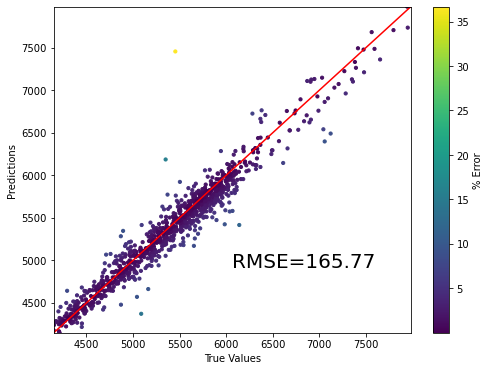

In [60]:
error = 100*abs(test_y['Teff']-test_predictions[:,0])/test_y['Teff']

rmse = np.sqrt(mean_squared_error(test_y['Teff'],test_predictions[:,0]))

x = np.arange(3500,9000,300)
fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y['Teff'], test_predictions[:,0],c=error,cmap='viridis',s=10)
plt.plot(x,x,'r-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.xlim(3500,9000)
#plt.ylim(3500,9000)
plt.xlim(np.min(test_predictions[:,0]),np.max(test_predictions[:,0]))
plt.ylim(np.min(test_predictions[:,0]),np.max(test_predictions[:,0]))

plt.text(0.5,0.2,'RMSE=%0.2f'%rmse,transform=plt.gca().transAxes,fontsize=20)
plt.colorbar(label='% Error')

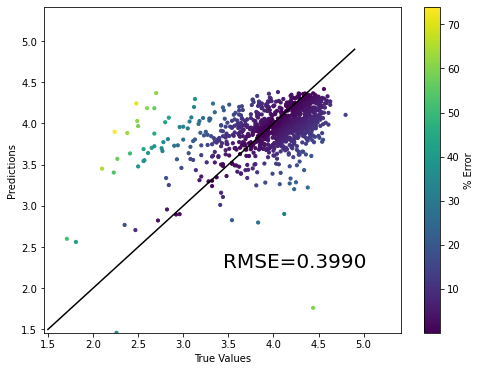

In [61]:
error = 100*abs(test_y['logg']-test_predictions[:,1])/test_y['logg']

rmse = np.sqrt(mean_squared_error(test_y['logg'],test_predictions[:,1]))

x = np.arange(1.5,5,0.1)
fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y['logg'], test_predictions[:,1],c=error,cmap='viridis',s=10)
plt.plot(x,x,'k-')
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.xlim(1.5,5)
#plt.ylim(1.5,5)
plt.xlim(np.min(test_predictions[:,1]),np.max(test_predictions[:,1]+1))
plt.ylim(np.min(test_predictions[:,1]),np.max(test_predictions[:,1]+1))

plt.text(0.5,0.2,'RMSE=%0.4f'%rmse,transform=plt.gca().transAxes,fontsize=20)

plt.colorbar(label='% Error')

# Teff, g and Z

In [62]:
df_Y = df_nonan[['Teff','logg','Z']]
df_X = df_nonan[['ug','gr','ri','iz']]
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_X_norm = (train_X - train_stats['mean']) / train_stats['std']
test_X_norm = (test_X - train_stats['mean']) / train_stats['std']

In [63]:
def keras_custom_lossfun(y_actual,y_predicted):
    custom_loss_value = (((((y_actual[:,0]-5416.829394)/671.423738) - ((y_predicted[:,0]-5416.829394)/671.423738) ))**2 +
                         ((((y_actual[:,1]-3.989970)/0.444576) - ((y_predicted[:,1]-3.989970)/0.444576) ))**2 +
                         ((((y_actual[:,2]+0.666404)/0.427591) - ((y_predicted[:,2]+0.666404)/0.427591) ))**2 
                        )
    return custom_loss_value

In [97]:
def build_model(n):
 
    inpt = keras.Input(shape=(n,), name='Input_layer')
    x = keras.layers.Dense(128, activation='relu')(inpt)
    #x = keras.layers.Dense(128, activation='relu')(x)
    #x = keras.layers.Dropout(0.1)(x)
    gen_dense_final = keras.layers.Dense(128, activation='relu')(x)
    
    temp = keras.layers.Dense(64, activation='relu')(gen_dense_final)
    temp = keras.layers.Dense(32, activation='relu')(temp)
    temp = keras.layers.Dense(32, activation='relu')(temp)
    temp = keras.layers.Dense(32, activation='relu')(temp)
    temp_out = keras.layers.Dense(1, activation='relu')(temp)
    
    logg = keras.layers.Dense(64, activation='relu')(gen_dense_final)
    logg = keras.layers.Dense(32, activation='relu')(logg)
    logg = keras.layers.Dense(32, activation='relu')(logg)
    logg = keras.layers.Dense(32, activation='relu')(logg)
    logg_out = keras.layers.Dense(1, activation='relu')(logg)
    
    Z = keras.layers.Dense(64, activation='relu')(gen_dense_final)
    Z = keras.layers.Dense(32, activation='relu')(Z)
    Z = keras.layers.Dense(32, activation='relu')(Z)
    Z = keras.layers.Dense(32, activation='relu')(Z)
    Z_out = keras.layers.Dense(1, activation='relu')(Z)
    
    model_out = keras.layers.concatenate([temp_out,logg_out, Z_out])
        
    model = keras.Model(inputs=inpt, outputs=model_out)
    
    model.compile(loss=keras_custom_lossfun,
                 optimizer='adam',
                 metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])
    
    
    return model


In [98]:
model_temp = build_model(len(train_X.columns))

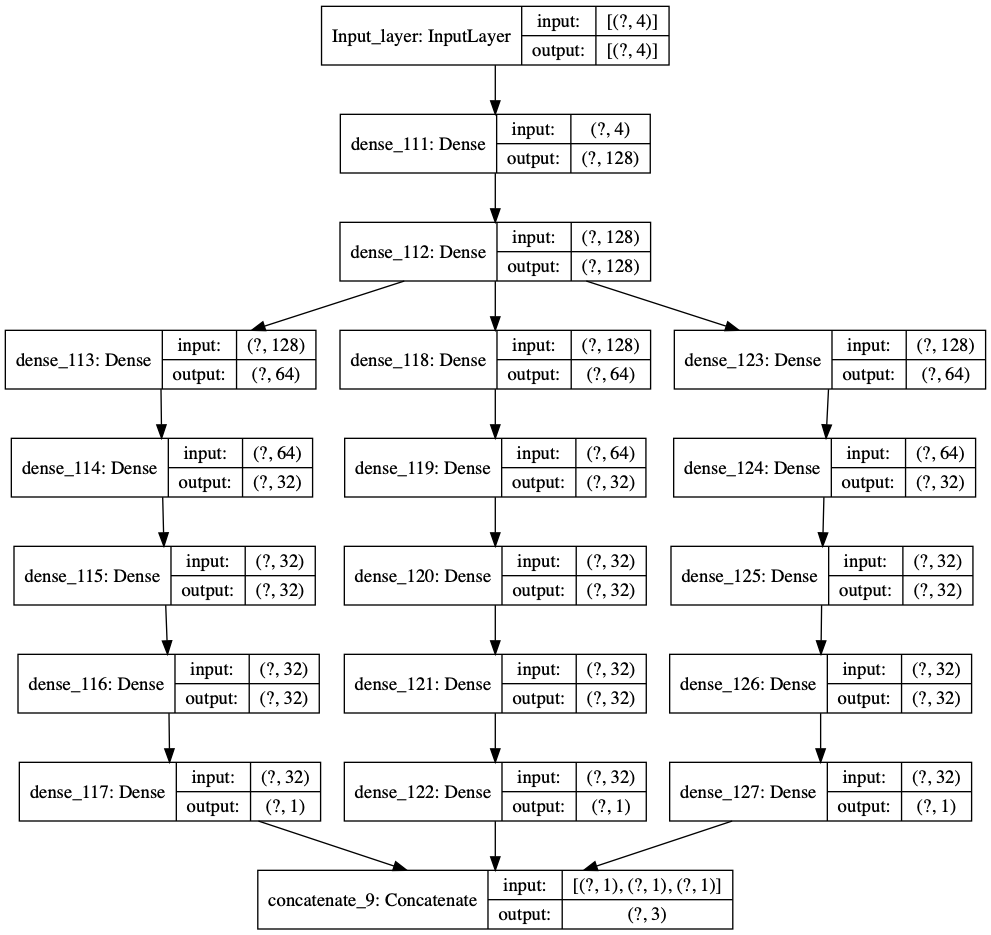

In [99]:
keras.utils.plot_model(model_temp,'split_model_3.png',show_shapes=True)

In [90]:
history = model_temp.fit(train_X_norm, train_y, epochs=300, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/300
2524/2524 [==============================] - 1s 476us/sample - loss: 113.9495 - mae: 1773.9202 - mse: 9589243.0000 - msle: 13.5668 - mape: 88.6733 - kullback_leibler_divergence: 6.0669 - val_loss: 66.0063 - val_mae: 1655.8903 - val_mse: 8384733.0000 - val_msle: 2.2157 - val_mape: 72.0639 - val_kullback_leibler_divergence: 0.0329
Epoch 2/300
2524/2524 [==============================] - 0s 75us/sample - loss: 20.8913 - mae: 604.7596 - mse: 2086730.0000 - msle: 0.3187 - mape: 50.0514 - kullback_leibler_divergence: 0.0327 - val_loss: 5.9621 - val_mae: 156.1267 - val_mse: 148525.8594 - val_msle: 0.0089 - val_mape: 39.7236 - val_kullback_leibler_divergence: 0.0329
Epoch 3/300
2524/2524 [==============================] - 0s 71us/sample - loss: 5.3478 - mae: 115.7126 - mse: 86707.2266 - msle: 0.0068 - mape: 38.8153 - kullback_leibler_divergence: 0.0327 - val_loss: 4.7601 - val_mae: 84.2204 - val_mse: 57819.5469 - val_msle: 0.0049 - val

In [91]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
295,4.251267,38.779041,8107.096680,0.002532,36.397900,0.032667,4.329444,37.061028,9922.087891,0.003347,36.743576,0.032868,295
296,4.246242,41.333817,8895.476562,0.002561,36.415104,0.032667,4.345581,40.123016,10462.523438,0.003404,36.805340,0.032868,296
297,4.224355,39.237862,8318.264648,0.002395,36.336845,0.032667,4.334059,44.149910,11593.885742,0.003468,36.779839,0.032868,297
298,4.217838,38.736561,8028.273926,0.002377,36.323242,0.032667,4.358537,39.651985,11542.112305,0.003497,36.686699,0.032868,298
299,4.193976,36.204056,7200.157715,0.002278,36.225544,0.032667,4.312591,42.776539,11265.992188,0.003373,36.748341,0.032868,299


Text(0, 0.5, 'loss')

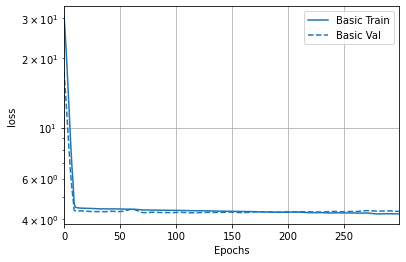

In [92]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = 'loss')
#plt.ylim([0, 20])
plt.yscale('log')
plt.ylabel('loss')

In [93]:
test_predictions = model_temp.predict(test_X_norm)

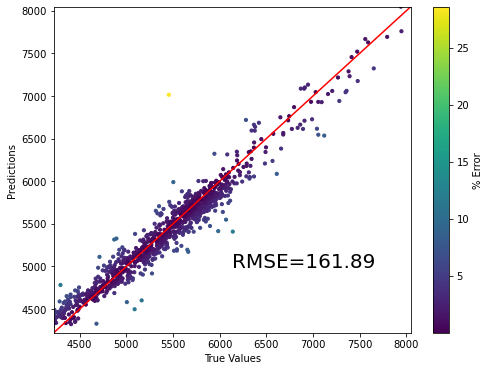

In [101]:
error = 100*np.abs(test_y['Teff']-test_predictions[:,0])/test_y['Teff']

rmse = np.sqrt(mean_squared_error(test_y['Teff'],test_predictions[:,0]))

x = np.arange(3500,9000,300)
fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y['Teff'], test_predictions[:,0],c=error,cmap='viridis',s=10)
plt.plot(x,x,'r-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.xlim(3500,9000)
#plt.ylim(3500,9000)
plt.xlim(np.min(test_predictions[:,0]),np.max(test_predictions[:,0]))
plt.ylim(np.min(test_predictions[:,0]),np.max(test_predictions[:,0]))

plt.text(0.5,0.2,'RMSE=%0.2f'%rmse,transform=plt.gca().transAxes,fontsize=20)
plt.colorbar(label='% Error')

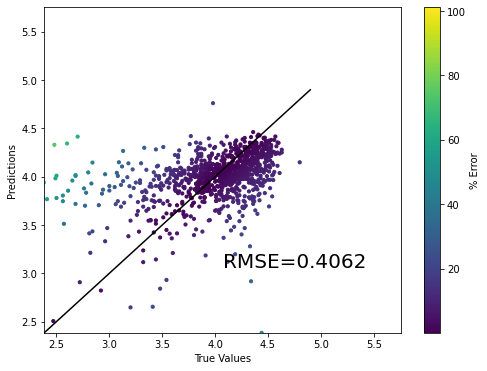

In [95]:
error = 100*abs(test_y['logg']-test_predictions[:,1])/test_y['logg']

rmse = np.sqrt(mean_squared_error(test_y['logg'],test_predictions[:,1]))

x = np.arange(1.5,5,0.1)
fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y['logg'], test_predictions[:,1],c=error,cmap='viridis',s=10)
plt.plot(x,x,'k-')
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.xlim(1.5,5)
#plt.ylim(1.5,5)
plt.xlim(np.min(test_predictions[:,1]),np.max(test_predictions[:,1]+1))
plt.ylim(np.min(test_predictions[:,1]),np.max(test_predictions[:,1]+1))

plt.text(0.5,0.2,'RMSE=%0.4f'%rmse,transform=plt.gca().transAxes,fontsize=20)

plt.colorbar(label='% Error')

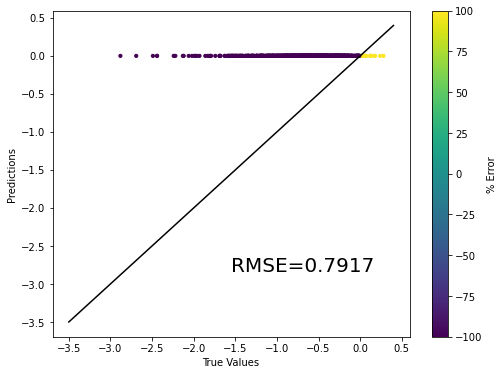

In [96]:
error = 100*abs(test_y['Z']-test_predictions[:,2])/test_y['Z']

rmse = np.sqrt(mean_squared_error(test_y['Z'],test_predictions[:,2]))

x = np.arange(-3.5,0.5,0.1)
fig = plt.figure(1,figsize=(8,6))
plt.scatter(test_y['Z'], test_predictions[:,2],c=error,cmap='viridis',s=10)
plt.plot(x,x,'k-')
plt.plot()
plt.xlabel('True Values')
plt.ylabel('Predictions')
#plt.xlim(1.5,5)
#plt.ylim(1.5,5)
#plt.xlim(np.min(test_predictions[:,1]),np.max(test_predictions[:,1]+1))
#plt.ylim(np.min(test_predictions[:,1]),np.max(test_predictions[:,1]+1))

plt.text(0.5,0.2,'RMSE=%0.4f'%rmse,transform=plt.gca().transAxes,fontsize=20)

plt.colorbar(label='% Error')